In [1]:
import matplotlib.pyplot as plt 
from preprocess import * 
from modeling import decompose
from visualize import lineplot, boxplot, heatmap
import seaborn as sns 
import numpy as np
# import pandas as pd 
import os
# from statsmodels.tsa.seasonal import seasonal_decompose


In [2]:
# Importing & Merging data files 
dir = '../data'
dat = merge_parquets(dir)

concatenating all yellow_tripdata parquets


In [3]:
# Random uniform sampling 
sampled_dat = sample_dat(dat, 0.3, 1)

In [4]:
# Removing outliers for trip distance, time duration, and total fare amount 
sampled_dat['time_duration_in_mins'] = (sampled_dat['tpep_dropoff_datetime'] - sampled_dat['tpep_pickup_datetime']).dt.seconds // 60
sampled_dat['trip_distance_round'] = np.floor(sampled_dat['trip_distance'])

sampled_dat = sampled_dat.groupby('trip_distance_round', group_keys=False).apply(lambda group: remove_outliers(group, 'total_amount'))
sampled_dat = sampled_dat.groupby('trip_distance_round', group_keys=False).apply(lambda group: remove_outliers(group, 'time_duration_in_mins'))
sampled_dat = sampled_dat.groupby('time_duration_in_mins', group_keys=False).apply(lambda group: remove_outliers(group, 'trip_distance_round'))


/var/folders/x0/rpxk2qtn1plg19j8v45ncgb80000gn/T/ipykernel_13544/2307729237.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_dat['time_duration_in_mins'] = (sampled_dat['tpep_dropoff_datetime'] - sampled_dat['tpep_pickup_datetime']).dt.seconds // 60
/var/folders/x0/rpxk2qtn1plg19j8v45ncgb80000gn/T/ipykernel_13544/2307729237.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_dat['trip_distance_round'] = np.floor(sampled_dat['trip_distance'])
/var/folders/x0/rpxk2qtn1plg19j8v45ncgb80000gn/

In [5]:
# Dropping to free up memory 
del dat 

## Temporal Patterns in the taxi fare

Can we find a temporal patterns in the taxi fare?

In [6]:
sampled_dat.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,time_duration_in_mins,trip_distance_round
647678,1,2023-02-07 16:54:18,2023-02-07 16:55:15,1.0,0.40,1.0,N,236,236,1,...,5.0,0.5,2.18,0.0,1.0,13.08,2.5,0.00,0,0.0
800220,2,2023-11-08 07:51:29,2023-11-08 07:51:36,1.0,0.00,1.0,N,138,138,2,...,5.0,0.5,0.00,0.0,1.0,11.25,0.0,1.75,0,0.0
1033681,1,2023-09-11 16:12:20,2023-09-11 16:12:23,6.0,0.00,1.0,N,145,145,2,...,2.5,0.5,0.00,0.0,1.0,7.00,0.0,0.00,0,0.0
2230449,2,2023-10-21 17:07:57,2023-10-21 17:08:21,1.0,0.01,1.0,N,234,234,4,...,0.0,0.5,0.00,0.0,1.0,7.00,2.5,0.00,0,0.0
1780564,1,2023-10-17 19:42:06,2023-10-17 19:42:21,1.0,0.00,1.0,N,100,100,2,...,5.0,0.5,0.00,0.0,1.0,9.50,2.5,0.00,0,0.0


In [7]:
# Extracting date, month, hour, dayname from pickup and dropoff timestamp columns
sampled_dat['tpep_date'], sampled_dat['tpep_month'] , sampled_dat['tpep_hour'], sampled_dat['tpep_dayname'] = extract_dt(sampled_dat['tpep_pickup_datetime'])
sampled_dat['tpep_drop_date'], sampled_dat['tpep_drop_month'] , sampled_dat['tpep_drop_hour'], sampled_dat['tpep_drop_dayname'] = extract_dt(sampled_dat['tpep_dropoff_datetime'])

# Splitting hours different timeblocks - '1.Morning (6am-10am)', '2.Midday (10am - 4pm)', '3.Evening Rush (4pm - 7pm)', '4.Night (8pm - 5am)'
sampled_dat['time_of_day'] = split_hours(sampled_dat['tpep_hour'])

/Users/jiwoojeong/Desktop/DSGA1007/DS1007_FinalProject/code/visualize.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x= xvar, y= yvar, data = dat, palette='Set3')


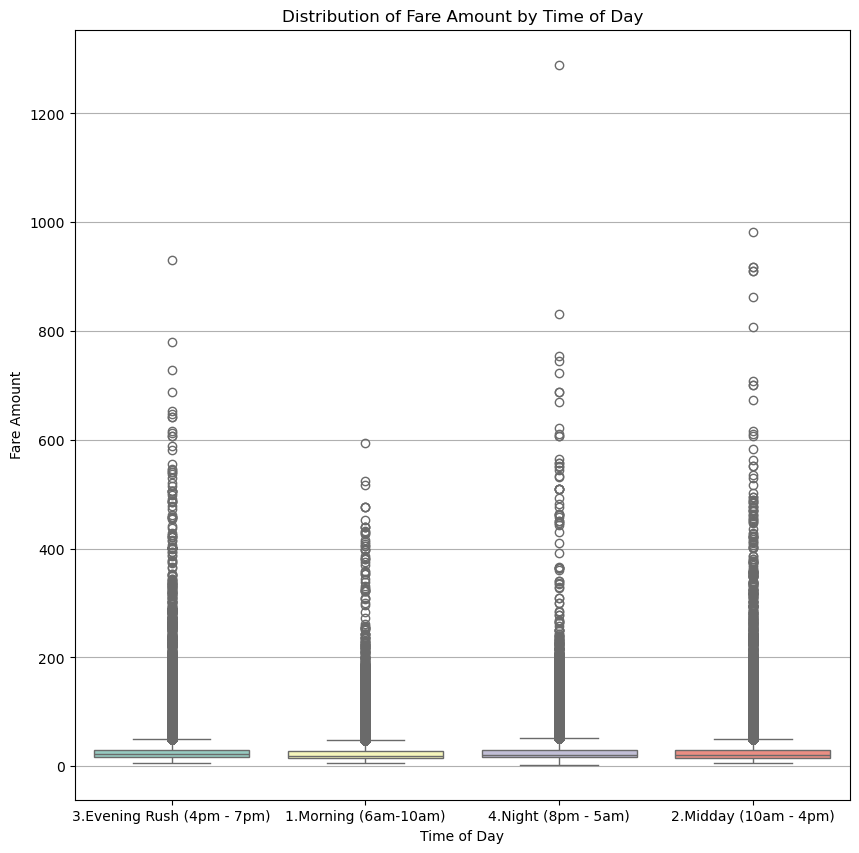

In [8]:
# Checking the distribution of fare amounts by time block 
boxplot(dat=sampled_dat, title = 'Distribution of Fare Amount by Time of Day', xvar = 'time_of_day', yvar = 'total_amount', xlabel='Time of Day', ylabel='Fare Amount')


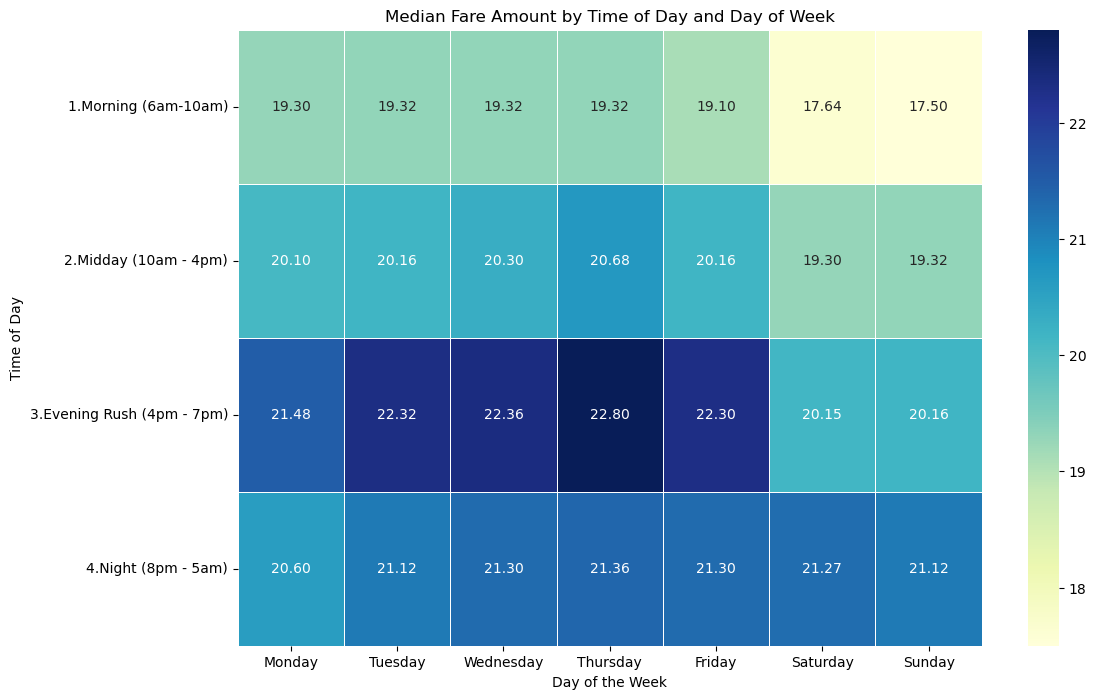

In [9]:
heatmap_data = sampled_dat.groupby(['time_of_day', 'tpep_dayname'])['total_amount'].median().unstack()

# Sort the day columns in order (if necessary)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data[day_order]

# Create a heatmap to display which time of a day x day of week tends to exhibit highest median fare amount 
heatmap(data = heatmap_data, title = 'Median Fare Amount by Time of Day and Day of Week', xlabel = 'Day of the Week', ylabel = 'Time of Day')

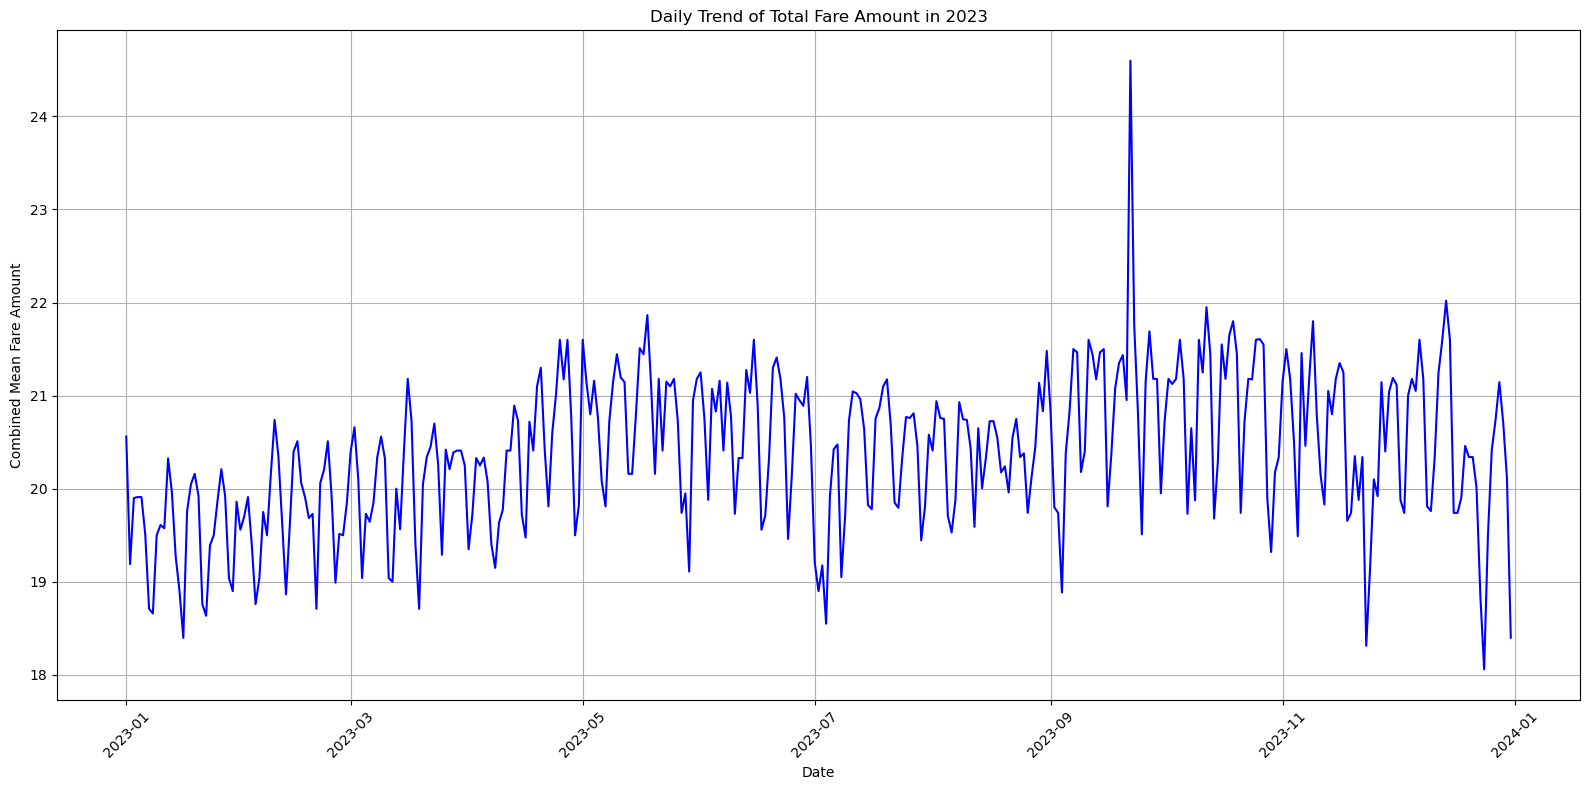

In [10]:
# Daily Trend of Total Fare Amount in 2023 
daily_mean_fare = sampled_dat[sampled_dat['tpep_pickup_datetime'].dt.year == 2023].groupby(['tpep_date', 'time_of_day'])['total_amount'].median().reset_index()

daily_combined_mean_fare = daily_mean_fare.groupby('tpep_date')['total_amount'].median().reset_index()

lineplot(daily_combined_mean_fare['tpep_date'], daily_combined_mean_fare['total_amount'], title = 'Daily Trend of Total Fare Amount in 2023',
xlabel = 'Date', ylabel = 'Combined Mean Fare Amount')


<Figure size 1500x1500 with 0 Axes>

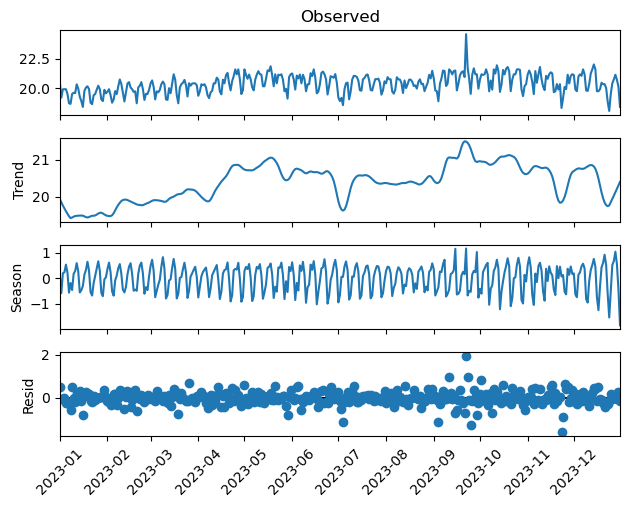

In [11]:
# Trend-Seasonality Decomposition of the overall taxi fare in year 2023 

total_seasonal = decompose(daily_combined_mean_fare, 'tpep_date')

1.Morning (6am-10am)


<Figure size 1000x1300 with 0 Axes>

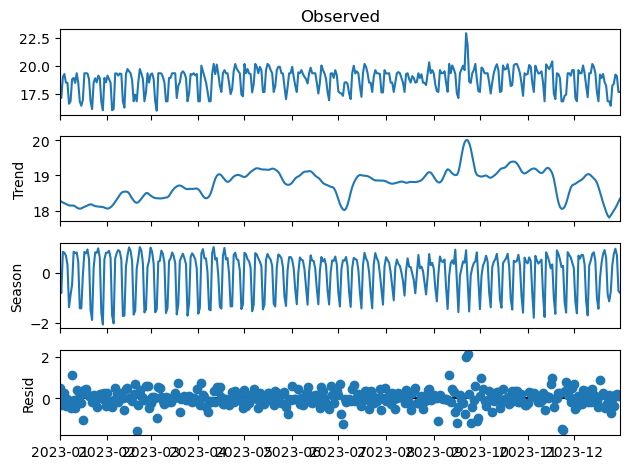

2.Midday (10am - 4pm)


<Figure size 1000x1300 with 0 Axes>

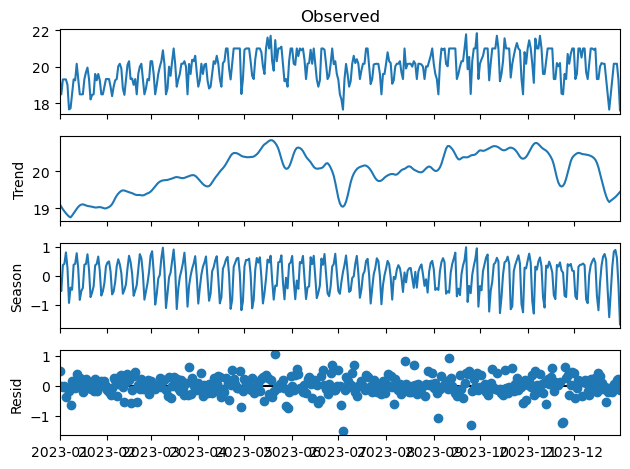

3.Evening Rush (4pm - 7pm)


<Figure size 1000x1300 with 0 Axes>

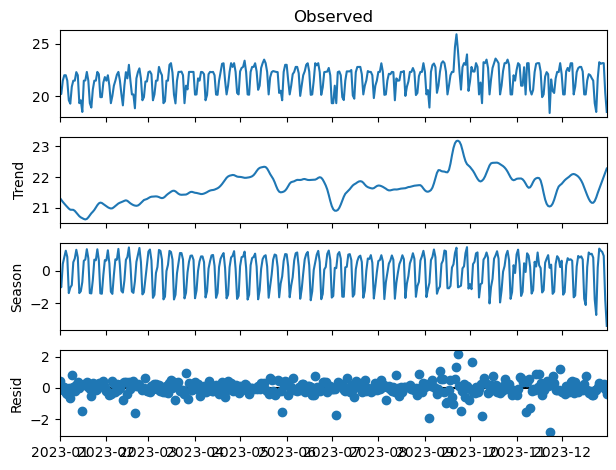

4.Night (8pm - 5am)


<Figure size 1000x1300 with 0 Axes>

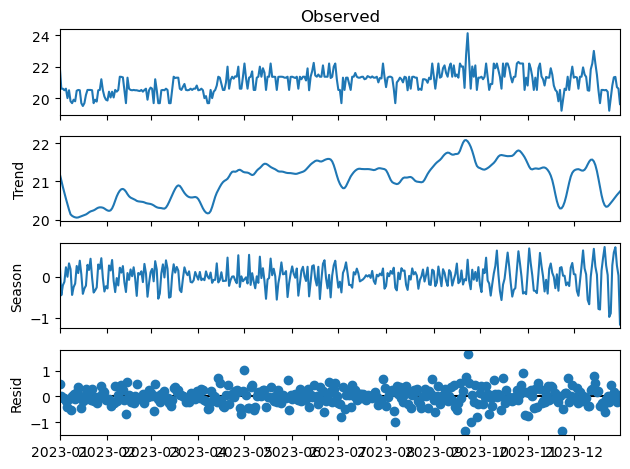

In [16]:
# Do the same for each time block - this is to only extract the seasonal component of each time block 
results = sampled_dat[(sampled_dat['tpep_pickup_datetime'].dt.year == 2023)].groupby(['tpep_date', 'time_of_day'])['total_amount'].median().reset_index()
time_blocks = ['1.Morning (6am-10am)', '2.Midday (10am - 4pm)', '3.Evening Rush (4pm - 7pm)', '4.Night (8pm - 5am)']
seasonality = {}
for t in time_blocks:
    t_result = results[results['time_of_day'] == t][['tpep_date', 'total_amount']]
    print(t)
    ts_result = decompose(t_result, 'tpep_date')
    seasonality[t] = ts_result
    
    

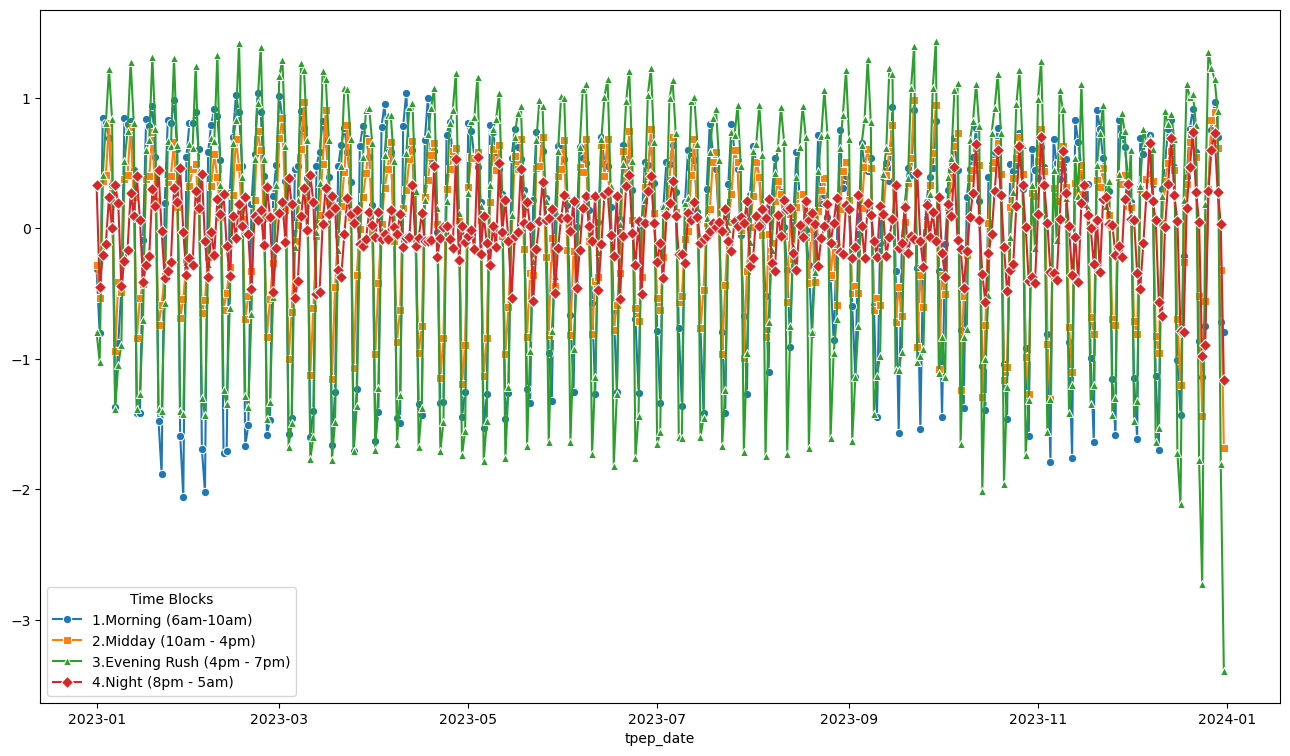

In [68]:
# Plotting just the seasonal component of each time block, to see which time block contributes most to the variability of seasonality 

plt.figure(figsize=(16,9))
markers = ['o', 's', '^', 'D']
for i, s in enumerate(seasonality):
    ss = seasonality[s]
    sns.lineplot(x=ss.index, y=ss.values, label=s, marker=markers[i])

plt.legend(title="Time Blocks", loc="best")

## Insights Drawn

* 1. On a macro-level, the daily median taxi fare in 2023 exhibits a relatively constant trend, with values typically fluctuating between 19 and 22. There is no clear evidence of a significant long-term upward or downward trend over the year.

        The relatively consistent trend suggests that taxi usage in NYC is influenced by consistent, year-round demand. This stability could reflect a reliable dependency on taxis as a core transportation mode, unaffected by broader economic or environmental factors. 

* 2. Despite the overall stability in the trend, the data exhibits a clear seasonal pattern, characterized by periodic peaks and troughs that suggest recurring fluctuations, potentially linked to time-of-week or time-of-year effects.

        The observed seasonal pattern suggests that taxi demand fluctates cyclically, potentially driven by commuters' weekly routines. 

* 3. When split into different time blocks, the taxi fare tends to be higher during weekdays, with peak fares occurring during Thursday Evening Rush (4pm - 7pm). Fares tend to drop significantly during weekends, especially in the Morning and Midday time blocks. 

        The higher fares during weekdays could indicate that taxis in NYC are frequently used for work-related travel, such as business trips, commuting to evening events, or returning from after-work engagements. The drop during weekends suggests that taxis may not be a primary transportation mode for leisure trips or family outings, as people might opt for public transport or personal vehicles during non-working days. 
        
* 4. The above statement is supported when looking at trend-seasonal decomposition of taxi fare history of each time block, where it shows a consistent peak in fares on Thursday Evening Rush (4pm - 7pm). Also this time block exhibits the highest variability in fares. 

        The consistent peak during Thursday Evening Rush and its high variability higlight this time block as a critical period of increased taxi demand. This could be attributed to a combination of different factors, such as late-week business activities, evening outings, or preparations for Friday. 
